# CS110 - LBA: A day in the Life of a Minervan

## Introduction

Today is a busy day.
I have to sleep, take CS110. A workout would be nice. Maybe work on a math assignment. Definitely take SS154 and the pre-class for it. Go to a cafe, shop for groceries. I would be happy if I could play some super smash - a videogame I play against my roommates. There is really a lot going on and I am not entirely sure which tasks to prioritize. I want to get as much value out of my day as possible, but I still don't want to overcommit myself and bite off more than I can chew...

Hopefully, I can build a scheduling algorithm to help me make my schedule.

# Scheduling Approach
1. Sort the task array based on start times.
2. For each task, identify which tasks it is compatible with.
3. Through exploring the space of possible combinations, based on compatibility data, identify the set of compatible tasks that will maximise value.
4. Print resulting schedule


#### Sorting by time
The array is sorted by time, because it allows for more efficient collision checking and schedule-value computations.

#### Collision check approach
Sorting the array by starting time allows us to divide the collision checking into two categories: checking collisions with activities that start earlier, and with those that start later.

We start checking the collisions in order of ascending start times. If a task does not collide with any other task, then we register "None" under collisions. This enables us to make more efficient the checking of collisions with tasks starting earlier than task[i]. If we start at task[i] and for collisions with tasks in order of descending start times, then for each task[j] with which we compare, the collisions have already been computed. Thus we may simply check if task[i] collides with task[j], if so: add task[j] to list of collisions. If  task[j] does not collide with any other task, then we know that no task before task[j] can collide with task[i] - Because otherwise that task would also be colliding with task[j].
Sorting by start, allows us to make more efficient the checking of collisions with tasks after task[i]. If task[j] represents some task later than task[i], if task[i] does not collide with task[j] than it cannot collide with any task later than task[j]. Because any such task is guaranteed to start later than task[j] by virtue of the tasks being sorted by start time.

This algorithm allows for the efficient creation of a list of the indices with which each task collide - the tasks with which a task does NOT collide it is therefore compatible with. This observation is used in scheduling.


#### Optimal Schedule approach
For each task, we generate every possible, valid schedule of which it could be part. This is done through looking at the list of indices of tasks with which it is compatible. For each other task[i] that it is compatible with, we look to see which tasks j1, j2, ..jn that it is compatible with. We store only the intersection of the two sets, i.e. we keep only tasks which work for every task in common.

To illustrate, imagine that task 1 is compatible with tasks [1,2,3]. We look at task 2, it is compatible with task [1,2,3]. [1,2,3][intersection][1,2] = [1,2], thus we know that all tasks that work for task 1 do not work for task 2 - 3 and two cannot be combined. We then look at task 3, it is compatible with [1,3,4]. [1,2,3][intersection][1,3,4] = [1,3], thus (we could technically have infered what the intersection of 1 and 3 would be based on the intersection of 1 and 2 - a potential way to improve the efficiency of the algorithm).

Doing this for every task in tasks, ensures that we capture every possible valid combination of tasks. For each such possible schedule, the value is then calculated. The valid schedule with the highest value is deemed to be the optimal schedule.

In [278]:
import datetime
import numpy as np
import pandas as pd

def scheduler(year, month, day, tasks):
    '''
    Takes a date and a lists of tasks.
    Returns the collision-free schedule that maximises value.
    
    Inputs:
    year = YYYY
    month = M
    day = D
    tasks = [[task], [task]]
    task in tasks  = ["activity", "start", "end", "value"]
    '''
    
    #Convert Hours and Minutes array to time object
    for task in tasks:
        #Start time
        task[1] = datetime.datetime(year, month, day, task[1][0], task[1][1])
        
        #End time
        task[2] = datetime.datetime(year, month, day, task[2][0], task[2][1])
    
    
    #Sort tasks by start time
    tasks.sort(key = lambda task: task[1]) 
    
    'For each task: Finds which, if any, tasks it collides with'
    n = len(tasks)
    index_list = [x for x in range(n)]
    
    #For each task
    for i in range(n):
        collisions = []

        start = tasks[i][1]
        end = tasks[i][2]
        
        #Check earlier tasks
        for j in reversed(range(0, i)):
            
            #If earlier task has no collisions, then it cannot collide with task[i]
            if tasks[j][4][0] is None:
                break
            
            #If task[j] collides with task[i], task[i] collides with task[j]
            if i in tasks[j][4]:
                collisions.append(j)
        
        #Check later tasks
        for j in range(i+1, n):
            if end > tasks[j][1]:
                collisions.append(j)
                
            #If task[i] does not collide with task[j], it cannot collide with task after j
            else:
                break
                
        #If no collisions, add None     
        if not collisions:
            tasks[i].append([None])
            tasks[i].append(index_list)

        
        #Append colliding and non-colliding tasks
        #Append non-colliding tasks
        else:
            tasks[i].append(collisions)
            tasks[i].append(list(set(index_list)-set(collisions)))
    
    
    'Find valid combinations of tasks'
    valid_schedules = []
    for task in tasks:
        
        #Start with values it is compatible with
        schedule = set(task[5])
        
        #Find the intersection of the tasks it is compatible with
        for i in task[5]:
            schedule = schedule & set(tasks[i][5])
        
        #Convert back to list; Find schedule corresponding to each index
        #Store resulting valid schedule
        valid_schedules.append([tasks[i] for i in list(schedule)])
        
    'Find the valid combination of tasks with the highest value'
    valid_schedule_values = []
    #For every schedule
    for schedule in valid_schedules:
        
        #Calculate the sum of task values in schedule
        value = 0
        for task in schedule:
            value += task[3]
        valid_schedule_values.append(value)
        
    #Find schedule with the highest value.
    optimal_schedule = valid_schedules[np.argmax(valid_schedule_values)]
    
    
    'Print schedule as a table with only relevant information'
    #Convert time objects to only include hour, minutes and seconds
    for task in optimal_schedule:
        #Start time
        task[1] = task[1] - datetime.datetime(year, month, day, 0, 0)
        
        #End time
        task[2] = task[2] - datetime.datetime(year, month, day, 0, 0)
        
    #Create Pandas dataframe for nice presentation
    schedule = pd.DataFrame.from_records(optimal_schedule, 
                            exclude = ["Value", "Collisions", "Compatible"], 
                            columns = ["Activity", "Start", "End", "Value", "Collisions", "Compatible"],)
    
    return schedule

In [292]:
#The tasks I am considering doing today
tasks = [["Sleep", [0, 0], [8, 0], 8],
         ["CS110", [9, 0], [10, 30], 100],
         ["SS154",  [19, 30], [21, 0], 100],
         ["SS154 Pre-Class Work", [17, 0], [19, 0], 100],
         ["Workout", [11, 0], [12, 0], 5],
         ["Go to Cafe", [13, 15], [13, 25], 3],
         ["Go home from Cafe", [19, 5], [19, 20], 7],
         ["Grocery Shopping", [15, 15], [15, 45], 3],
         ["Online Lecture", [12, 0], [13, 0], 2],
         ["Work on Math assignment", [11, 0], [14, 0], 6],
         ["Play Super Smash", [11, 10], [11, 30], 2],
        ]


#Let's make the schedule!
scheduler(2019, 5, 2, tasks)

Activity    Start      End
0                 Sleep 00:00:00 08:00:00
1                 CS110 09:00:00 10:30:00
2               Workout 11:00:00 12:00:00
3        Online Lecture 12:00:00 13:00:00
4            Go to Cafe 13:15:00 13:25:00
5      Grocery Shopping 15:15:00 15:45:00
6  SS154 Pre-Class Work 17:00:00 19:00:00
7     Go home from Cafe 19:05:00 19:20:00
8                 SS154 19:30:00 21:00:00

# Evaluation and Analysis of Scheduling Algorithm

Benefits:
1. Very easy to follow, clear structure. I must say that the schedule was very clear and easy to read. I put it as the screensaver on my phone for the day and it was really helpful to just be able to look down and immediately see what I had to do and when I had to do it.

2. Just creating the set of tasks that the algorithm requires as input requires you to put meaningful thought into the day ahead. Honestly, I found this to be very beneficial in its own right. It is very easy to become reactive, the human bias of WYSIATI - "What you see is all there is" - makes it very easy to loose sight of what tasks actually deliver value to your life in the long-run when faced with immediate pleasure (Kahneman, 2012). This process forced me to think seriously about what alternatives I had and, perhaps more importantly, in putting a value on it it allowed me to be much more objective in my scheduling optimisation. That is, it is very easy to be objective when putting a number to a task in a list, it is harder to convert that into an action in your day - the schedule helped that.

Problems
1. No buffer or margin for error. 
Today things started out well enough. I woke up on time and got to class on time. However, I had forgotten to account for the time it would take for me to shower and get dressed after working out. Because there was no buffer built into the schedule, this resulted in my running behind schedule for most of the day. In the end I had to spend a little less time on SS154 pre-class than I had planned for. Luckily, this time that was not a problem. However, it is easy to see that it could have been one.
In my view, there are two ways to solve this. The easiest of the two would be to account for this when estimating the times for each activity. That is, if I know the time I take to workout varies, I could account for that by allowing for more time in my schedule - say, by adding an additional 20 minutes to "workout". Alternatively, I could build an optional argument called buffer adds a buffer of x time to the schedule. Or, perhaps better still, I could add a "adjust" functionality to update the schedule if I am running ahead or behind time. So that the every task in the schedule is either pushed back or moved earlier by some fixed amount of time. This would introduce some flexibility into the system.

2. Essentially making your own schedule.
In my view, the primary shortcoming of this scheduler is that it seems to be solving the wrong problem for it to be valuable to me in my everyday life. The scheduler requires a start and an end time for each activity, given that it creates the collision-free schedule that maximises value. The drawback is that this is a task I am already quite adept at. Consequently, I see the main use-case for this scheduler as being if you have a very large set of competing tasks for a day, to the point where it becomes hard to do the required mental math. In light of this, it would make a lot of sense to have a list of standard tasks, i.e. things that are always good to do on any given day but easy to forget, e.g. stretch after working out, which are always passed to the scheduler.

3. Only one day. 
Currently, the scheduler cannot accomodate for tasks which transcend days. For example, I could not schedule sleep from 11p.m Monday to 8am Tuesday. However, I built the scheduler on the datetime module, which makes it a straight forward process to modify the scheduler to accomodate for schedules that are longer than one day if one would wish to do so.

Potential modifications
1. Dynamically fit tasks which have only a known duration, but flexible start and end times. This would allow for (1) a life-task list where you add everything you need to do at some point. E.g. file-taxes, sign housing agreement, do laundry, book flights etc. Which you could pass as a secondary set of tasks to the scheduler. If your schedule has gaps in it, these tasks could be added in there. This would be really helpful, especially for helping to remember to do these sort of one-of yet important tasks. If I were to add one functionality, it would be this.
2. Non-colliding groups of tasks can be considered independent subproblems. Consequently, we could divide the list of tasks into groups of colliding tasks. We can then find the optimal, valid schedule in for each group. We then combine each subsolution, from earlier to later, to create the globally optimal schedule. Ultimately, this would require less fewer intersection comparisions, and thus be more efficient.

# HC Appendix

### #Audience. 
In evaluating the benefits and drawbacks, I do so whilst balancing the fact that at the end of the day this scheduling algorithm is meant to be helpful to me - and as such my personal experience and opinion matter - with the knowledge that a professor will have to read this. I hope a struck good balance between personal experience and objective critique in a way that can be appealing to objectives. Furthermore, I give a written account of my approach to the scheduling problem, such that it will provide context for the reader to make the code easier to follow.

### #Organisation.
I think the organisation of this assignment is clearly, logically structure which eases the flow of reading and makes more effective the delivery of the message - I hope. Before going into the code I give a written account of the idea behind it, it too logically structured.

### #Contraints
Whilst it is possible to imagine more contraints that could be added to this scheduler, it is nevertheless the case that constraint satisfaction was a central component in this scheduling algorithm. No two activities in a task can collide/overlap, such is the core constraint of a schedule. The obstacle is making sure we combine non-colliding activities into a schedule that maximises.

### #Decisionselection
I identify a logical objective function for making my optimal schedule: the valid schedule - i.e. where there are no collding tasks - that maximises the value that I get out of my day. The application of this decision selection is clearly described in both the written account and the algorithm itself - the algorithm even shows a step by step process for how it was derived.

### #Optimisation.
Given the constraint: No two activities in a task can collide/overlap. And the objective: find the valid schedule - i.e. where there are no collding tasks - that maximises the value that I get out of my day. I define an optimisation problem. I solve it by exploring the space of all possible solutions that satisfy the contraint and then selecting the one that best meets the decision criteria. Entire process clearly documented.


# Picture proof

Me at the cafe,
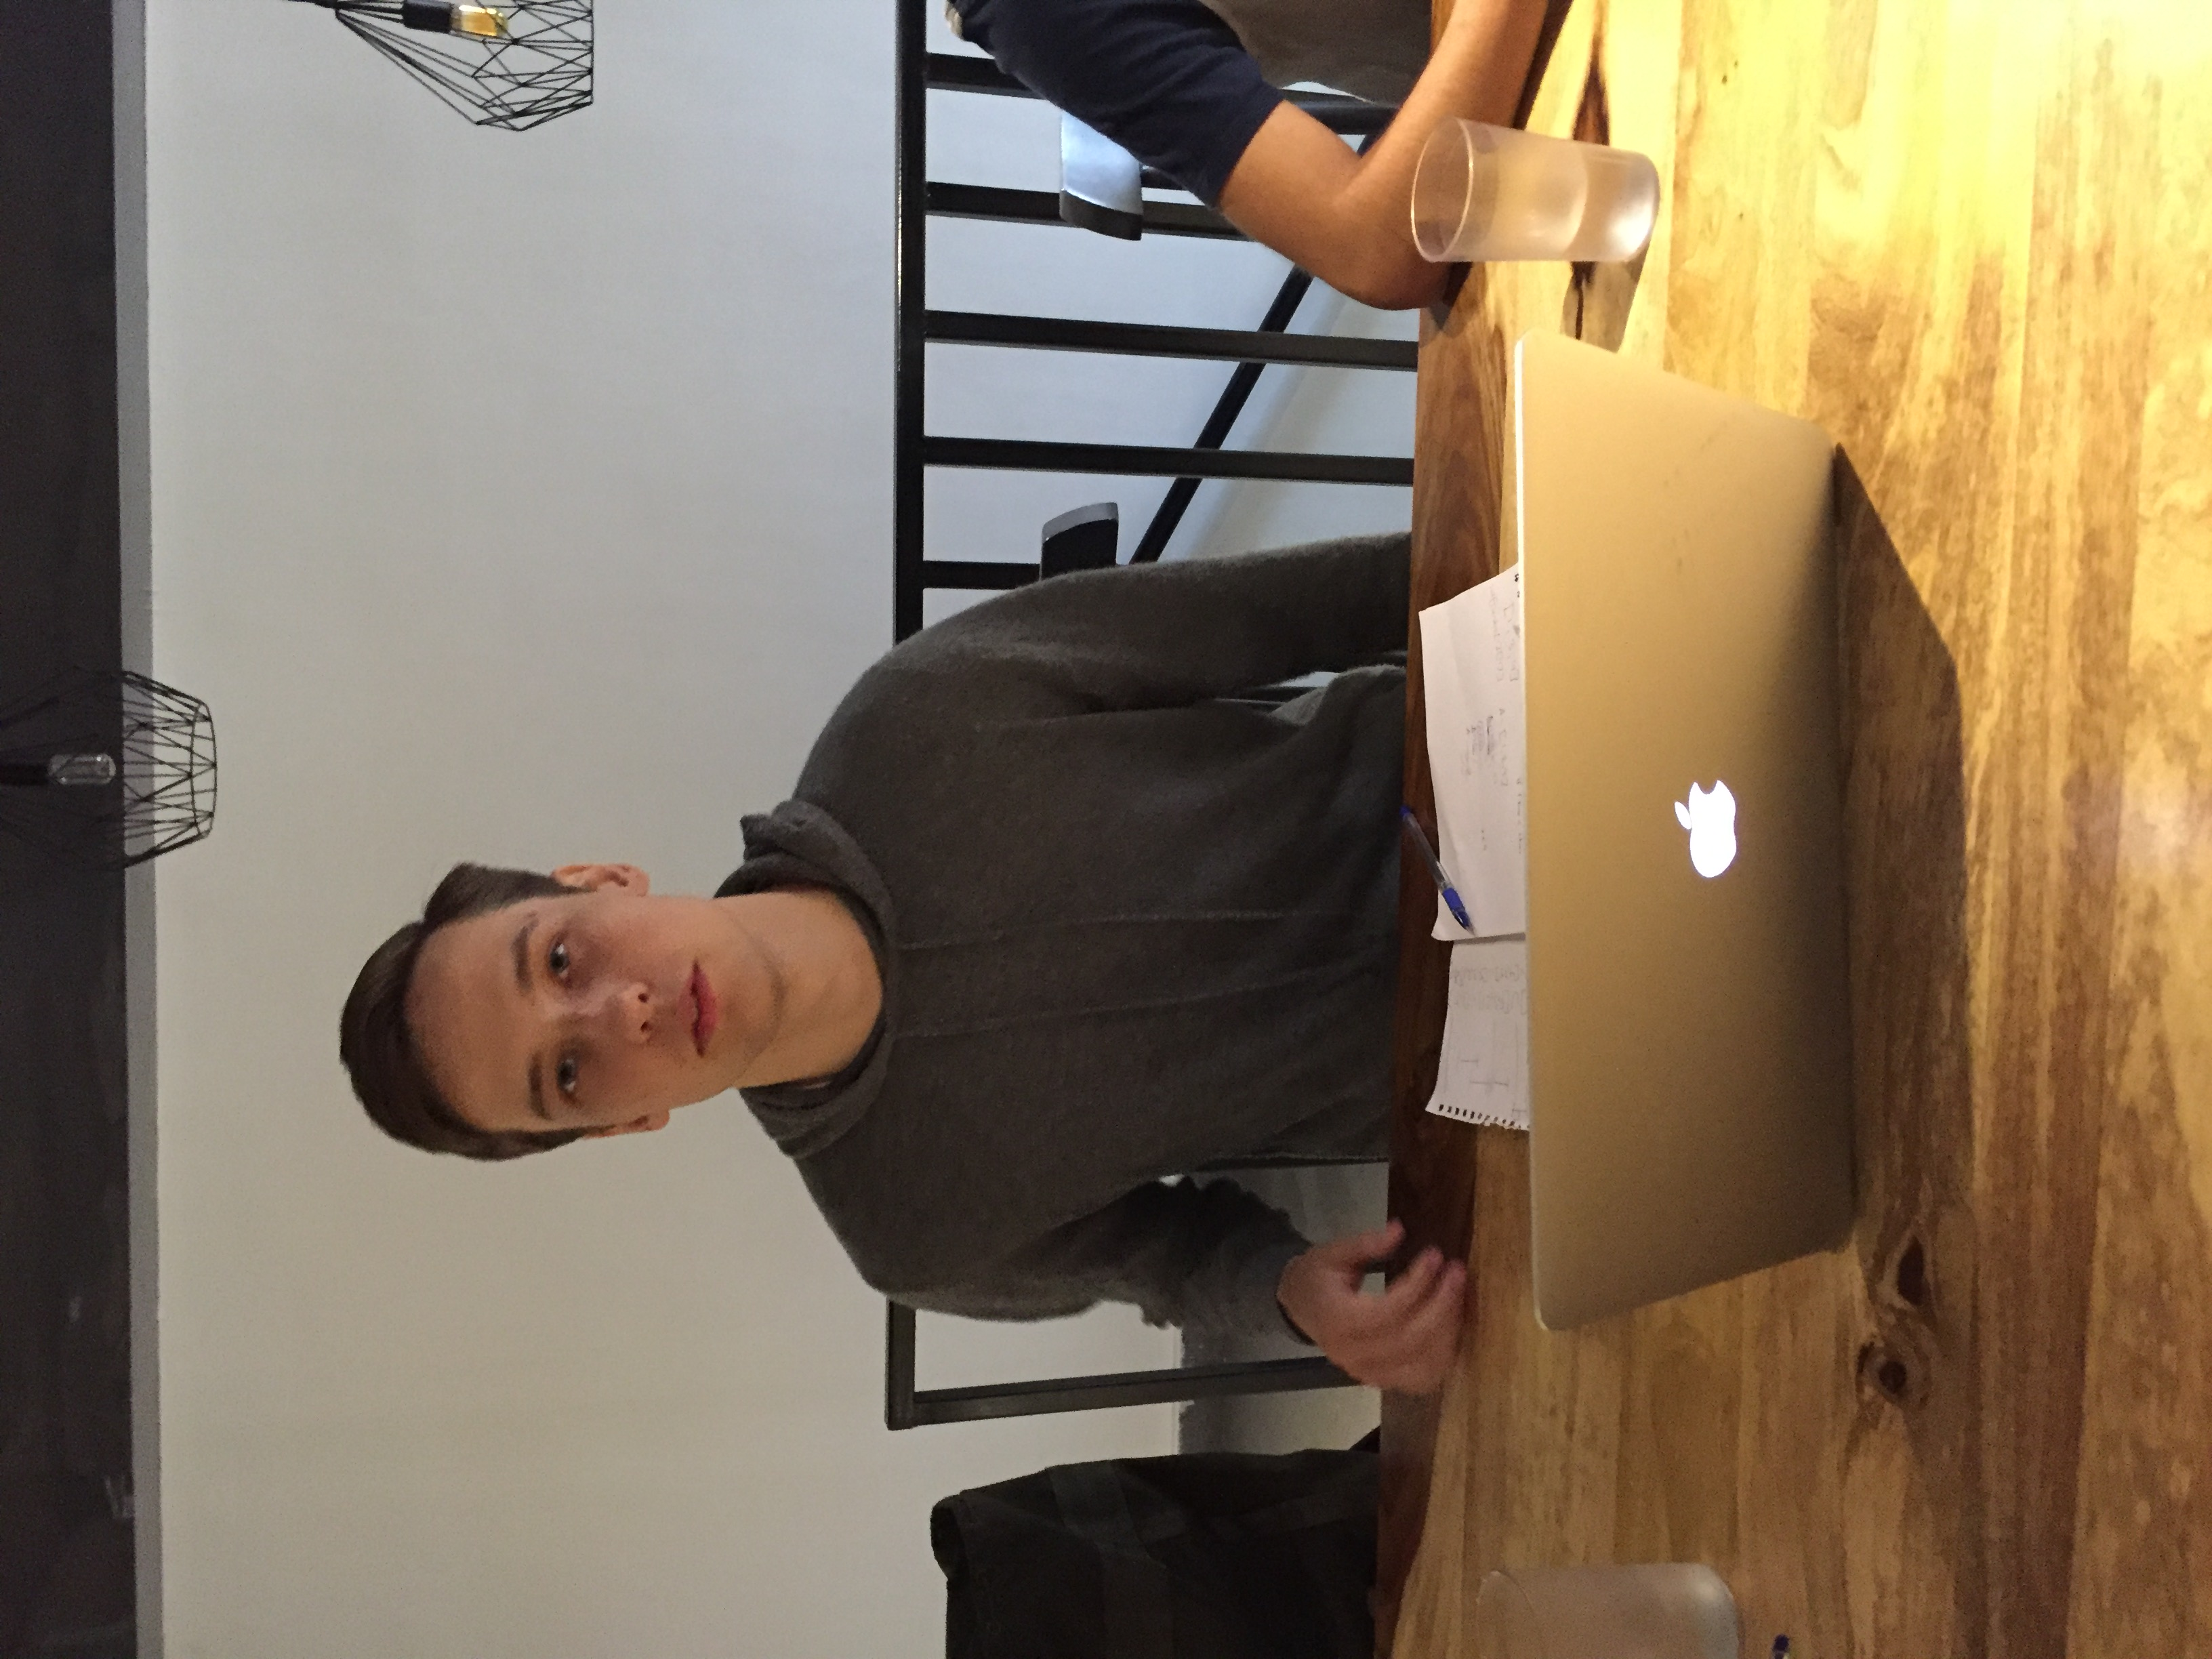

Me shopping groceries,
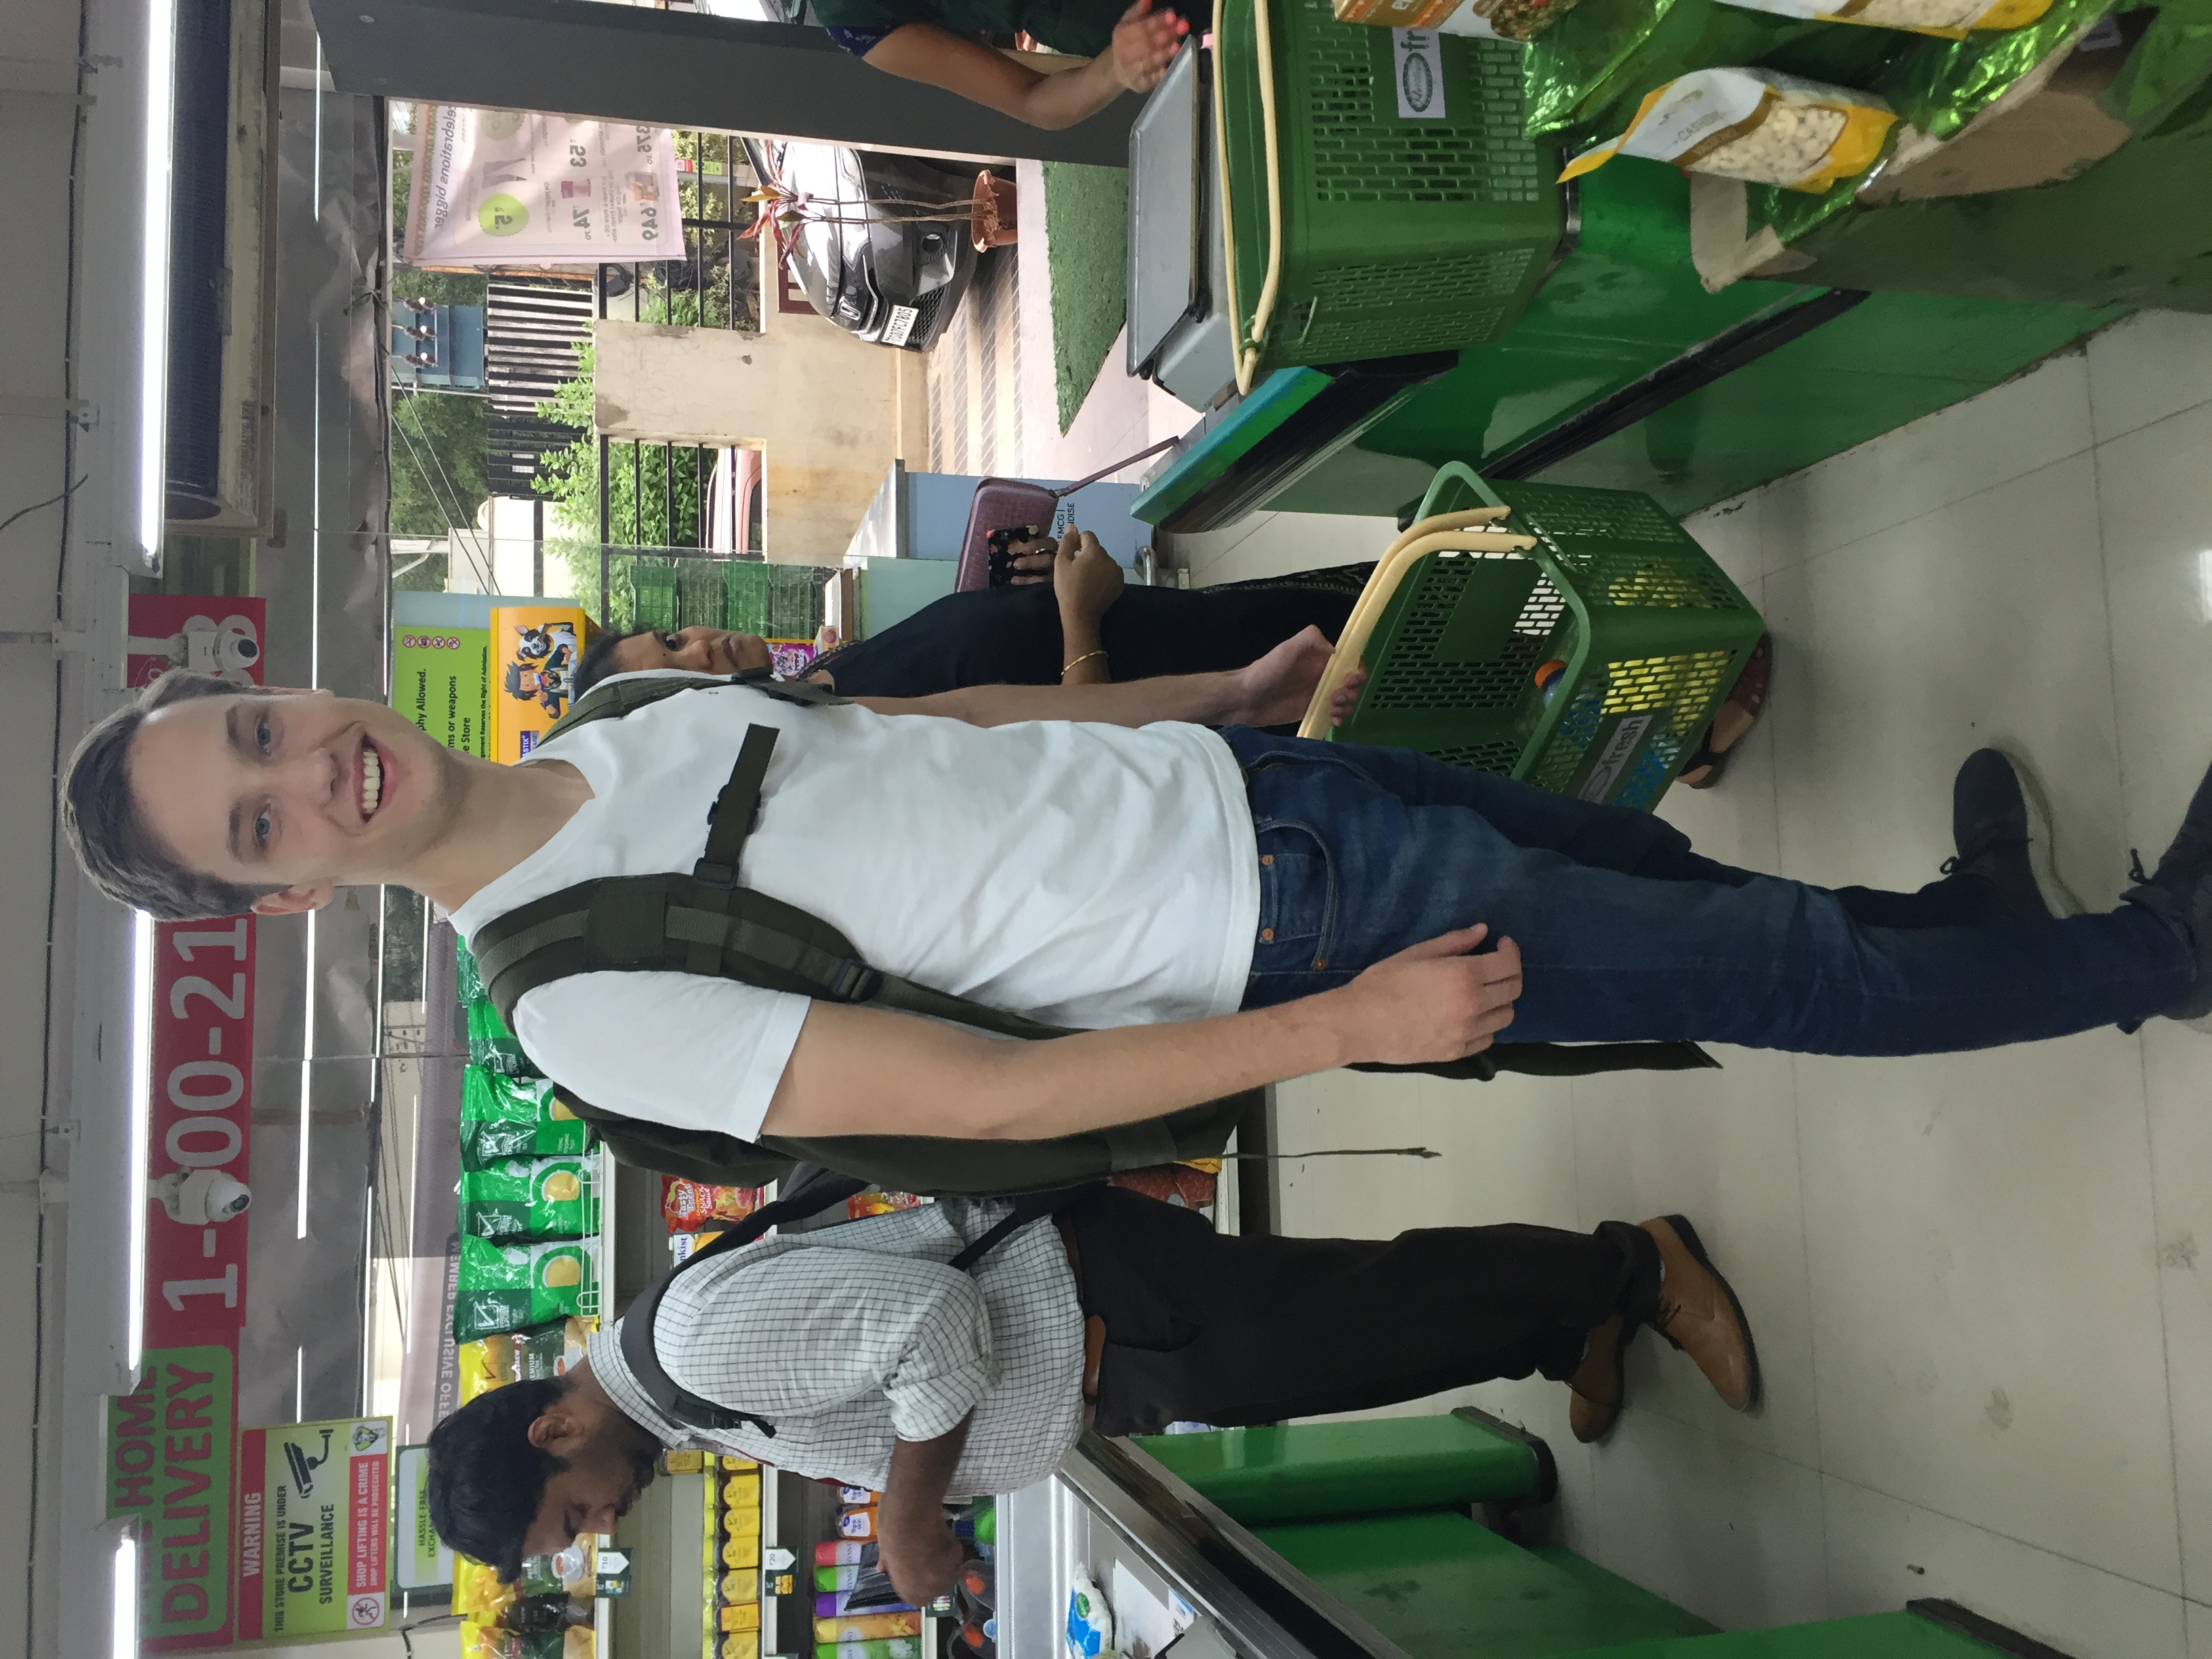

I forgot to take a picture at the gym, but here is a picture of me right before I hop into the shower after having been to the gym.
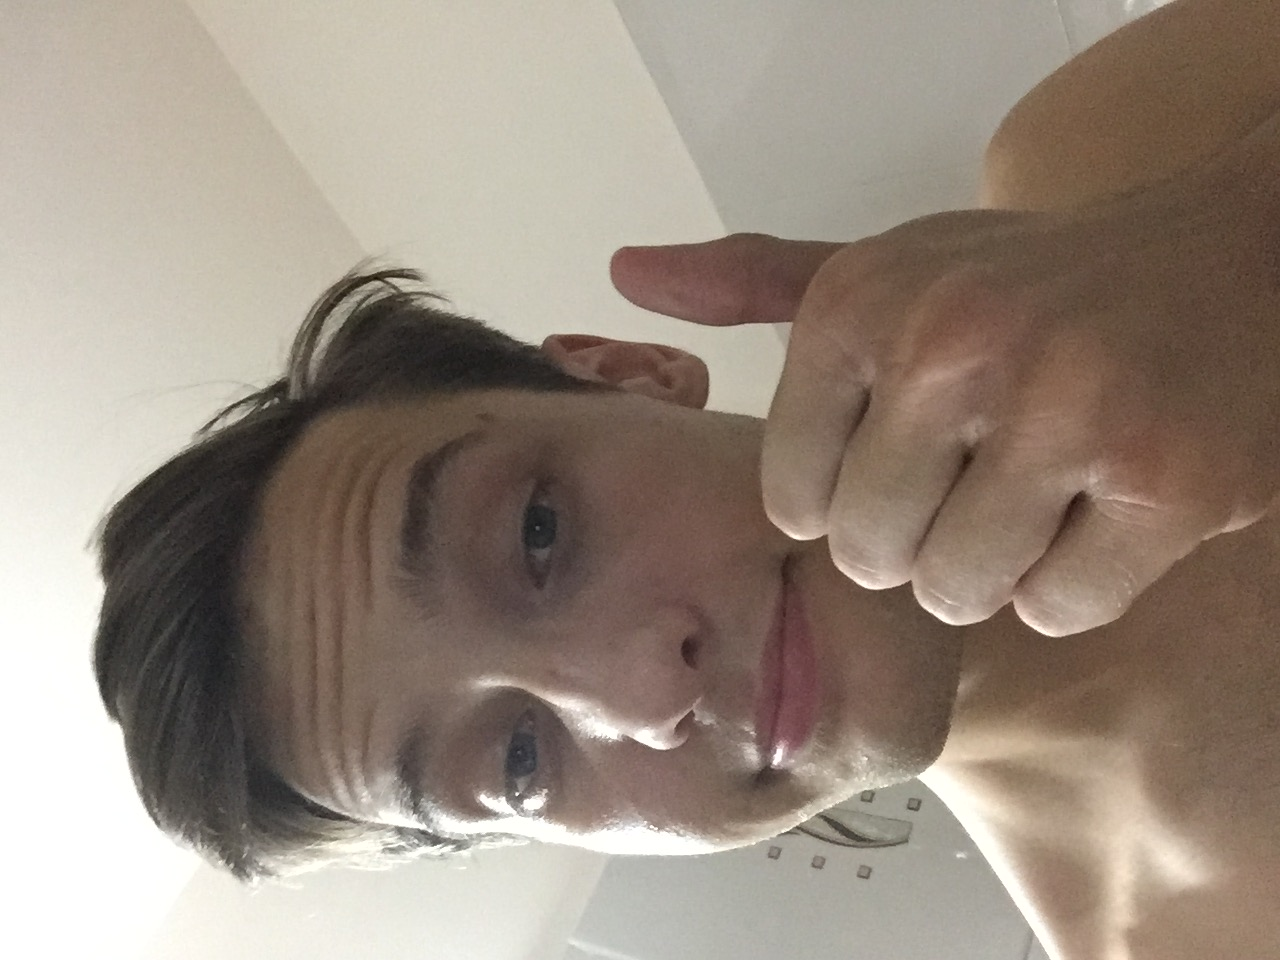